### Regression with Decision Tree and Random Forest

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFECV
import sklearn.metrics as sm
pd.set_option('display.max_columns', None)

#### Read the training set

In [2]:
df=pd.read_csv('X_train.csv')
df.head()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Licensed,official_video,ifTop100,trackLength,albumLength,ArtistEqualsChannel,album_tracks,available_markets,album_release_days,Album_type_album,Album_type_compilation,Album_type_single,target
0,0.407,0.358,9.0,-12.908,0.0343,0.829,0.424000,0.0827,0.267,92.292,284800.0,29700954.0,121515.0,4260.0,0.0,0.0,0,11,7,0,9,184,19183,1,0,0,78507272.0
1,0.463,0.325,11.0,-14.762,0.0301,0.197,0.000000,0.0641,0.386,135.728,283133.0,1159190.0,3822.0,84.0,0.0,0.0,0,22,12,0,10,2,11778,1,0,0,134634501.0
2,0.253,0.189,8.0,-17.741,0.0348,0.856,0.000004,0.1120,0.143,133.591,152000.0,3309.0,31.0,3.0,0.0,0.0,1,55,33,0,12,25,22005,1,0,0,18549494.0
3,0.828,0.539,1.0,-7.300,0.2250,0.205,0.000038,0.3050,0.680,125.050,189171.0,460685.0,19970.0,817.0,0.0,1.0,0,12,12,1,1,183,64,0,0,1,1146962.0
4,0.395,0.288,11.0,-10.465,0.0345,0.656,0.000000,0.1160,0.189,130.571,238640.0,1870346.0,22327.0,1097.0,1.0,1.0,0,47,20,0,15,184,694,1,0,0,70267624.0


In [3]:
df.shape

(14560, 27)

Variables distribution

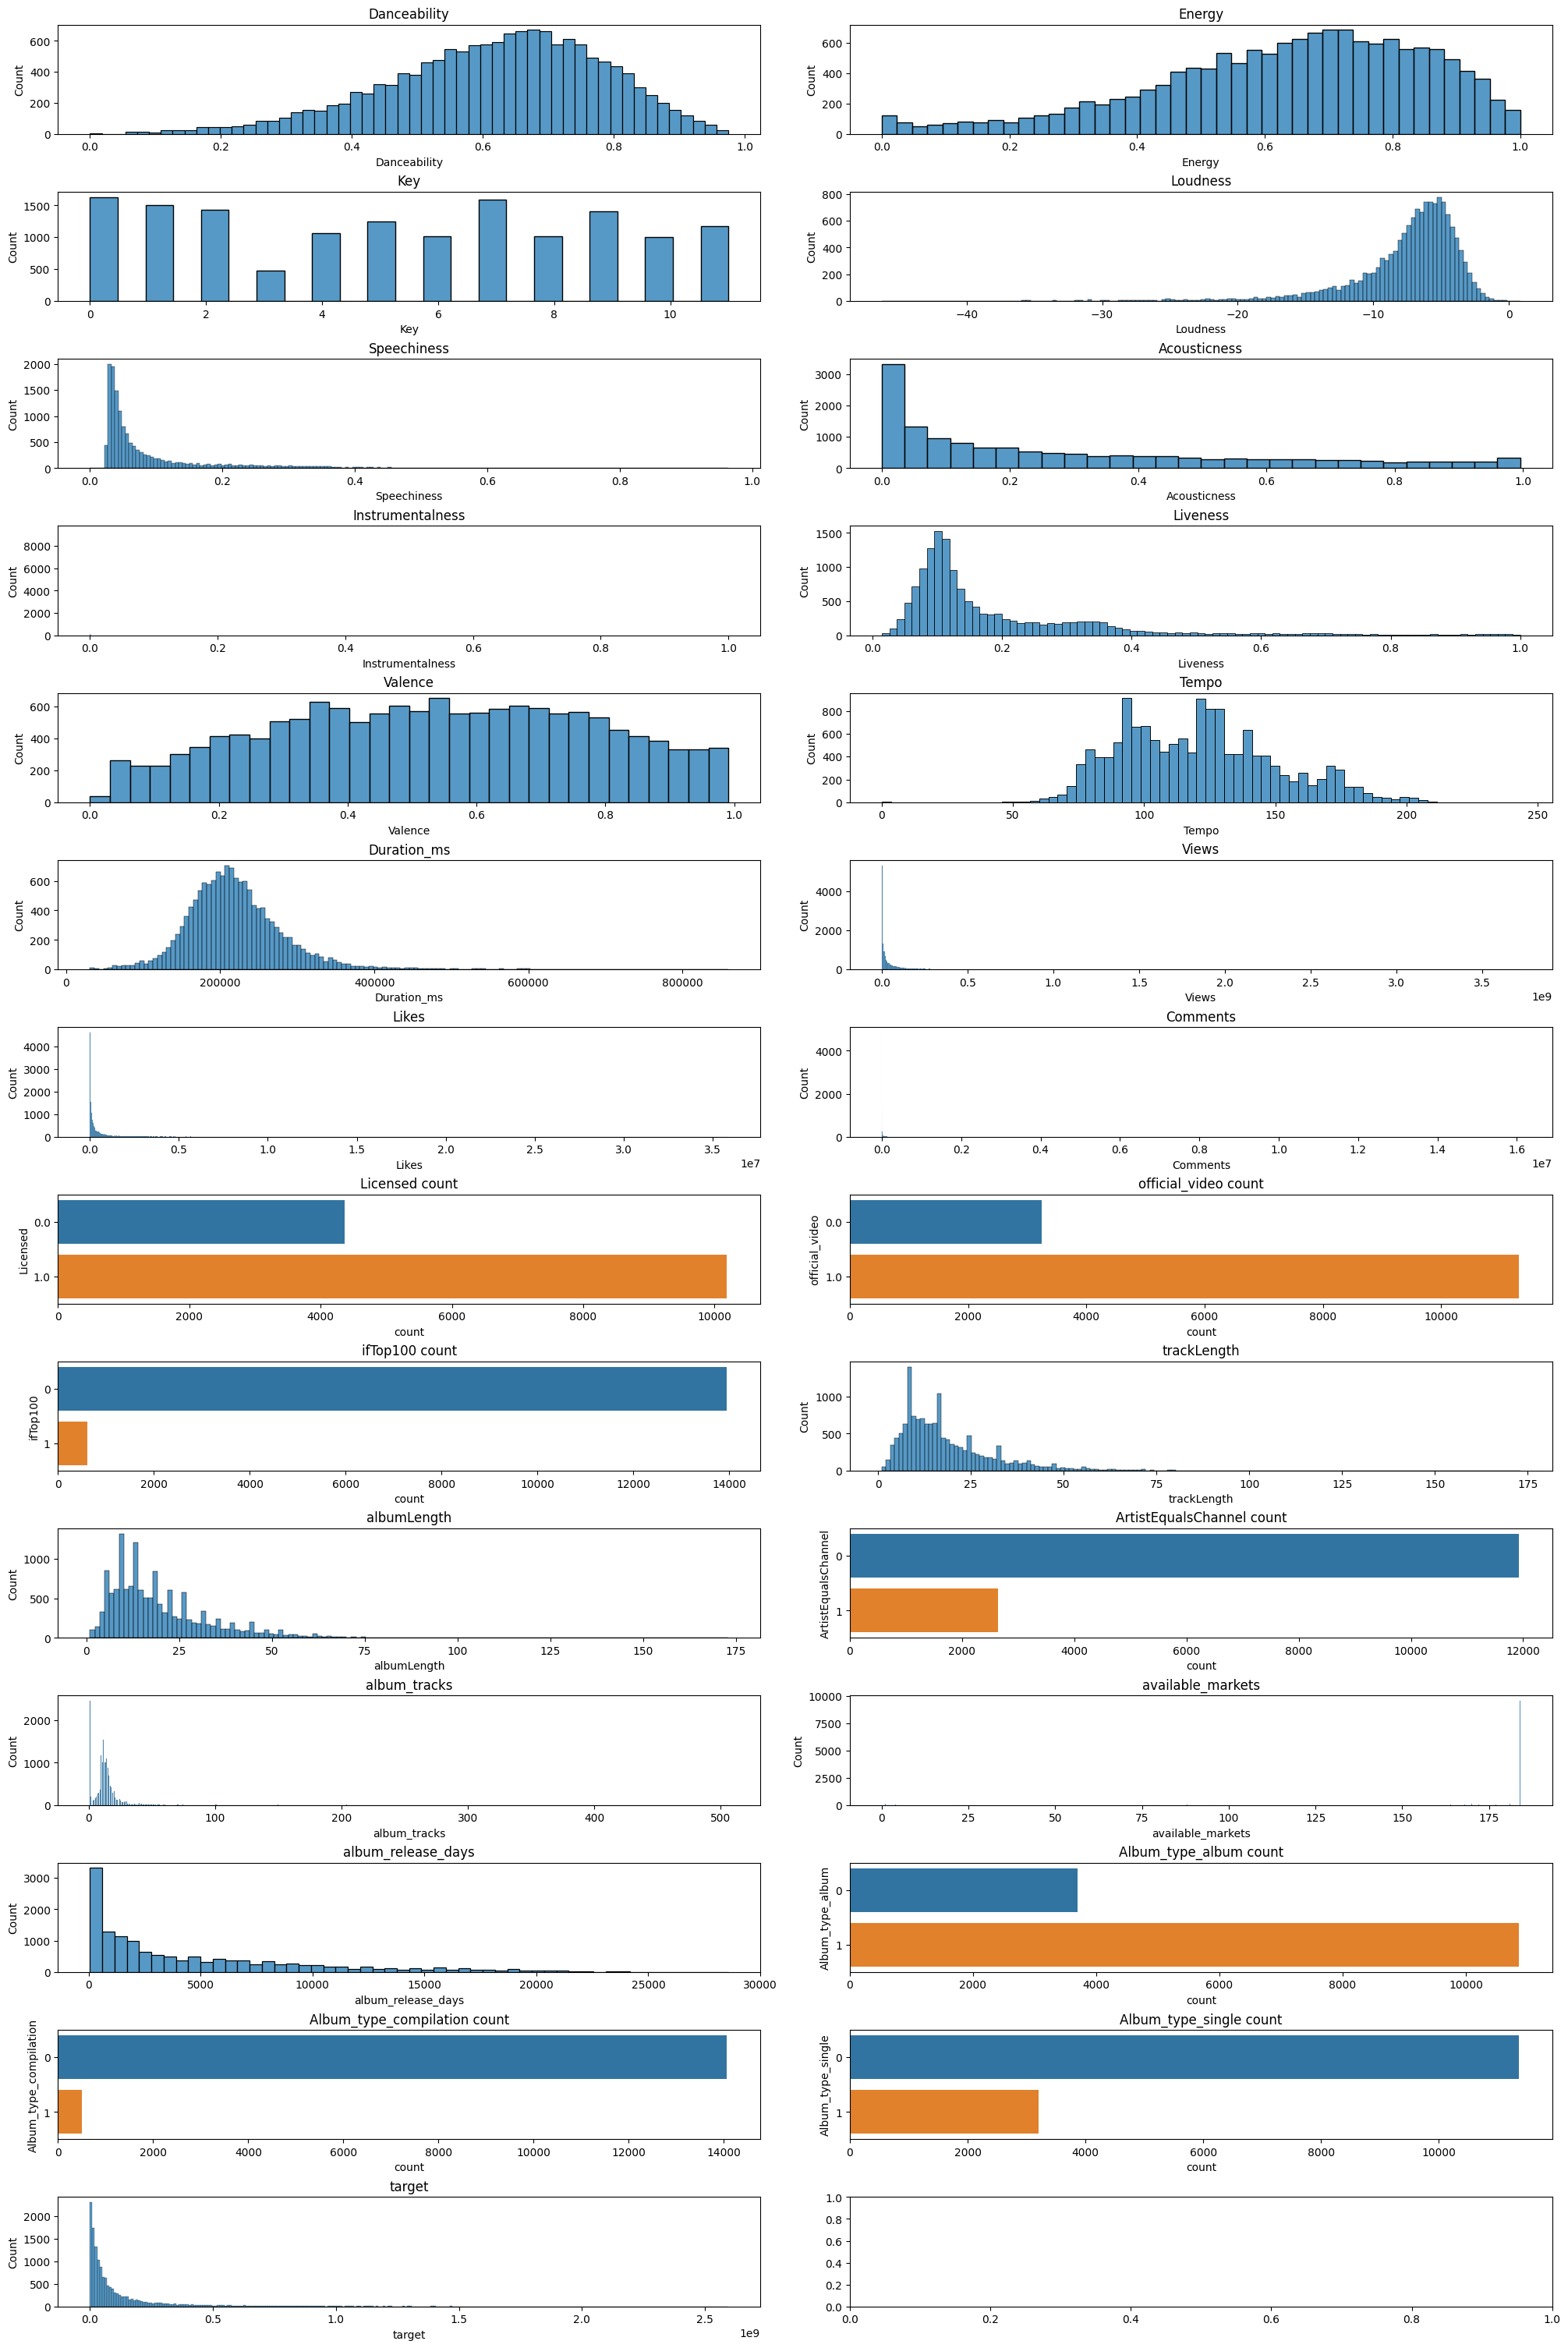

In [4]:
def plotting_features(data,cols):
    
    '''
    Return to distribution of numerical features and count of 
    categorical features, specific features will ignore them,
    because they do not give us any meaning.
    
    '''
#     cols = [ col for col in data.columns if col not in ignored_cols]
 
    nrows= int(np.ceil(len(cols)/2))
    fig, ax = plt.subplots(
                        nrows=nrows, 
                        ncols=2, 
                        figsize=(20,30),   
                        constrained_layout=True)
    ax = ax.ravel()
 
    for i in range(len(cols)):
        if (data[cols[i]].dtypes == 'object') or (len(data[cols[i]].unique().tolist()) < 10): 
            
            sns.countplot(y = data[cols[i]], ax=ax[i])
            ax[i].set_title(f'{cols[i]} count')
 
        else:
            sns.histplot(x = data[cols[i]], ax=ax[i])
            ax[i].set_title(f'{cols[i]}');
plotting_features(df,df.columns)

#### Split the dataframe into X and Y

In [8]:
Y=df['target'].values
X=df.drop(['target'],axis=1)

In [7]:
X.head()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Licensed,official_video,ifTop100,trackLength,albumLength,ArtistEqualsChannel,album_tracks,available_markets,album_release_days,Album_type_album,Album_type_compilation,Album_type_single
0,0.407,0.358,9.0,-12.908,0.0343,0.829,0.424000,0.0827,0.267,92.292,284800.0,29700954.0,121515.0,4260.0,0.0,0.0,0,11,7,0,9,184,19183,1,0,0
1,0.463,0.325,11.0,-14.762,0.0301,0.197,0.000000,0.0641,0.386,135.728,283133.0,1159190.0,3822.0,84.0,0.0,0.0,0,22,12,0,10,2,11778,1,0,0
2,0.253,0.189,8.0,-17.741,0.0348,0.856,0.000004,0.1120,0.143,133.591,152000.0,3309.0,31.0,3.0,0.0,0.0,1,55,33,0,12,25,22005,1,0,0
3,0.828,0.539,1.0,-7.300,0.2250,0.205,0.000038,0.3050,0.680,125.050,189171.0,460685.0,19970.0,817.0,0.0,1.0,0,12,12,1,1,183,64,0,0,1
4,0.395,0.288,11.0,-10.465,0.0345,0.656,0.000000,0.1160,0.189,130.571,238640.0,1870346.0,22327.0,1097.0,1.0,1.0,0,47,20,0,15,184,694,1,0,0


## Applying transformations with Boxcox

In [9]:
from scipy import stats
def boxcoxTransformation(data,column):
    # transform training data & save lambda value
    fitted_data, fitted_lambda = stats.boxcox(data)
    
    binwidth=1
    
    # Set up the plot
    ax = plt.subplot(1, 2, 1)
    
    # Draw the plot
    ax.hist(data, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    ax.set_title('Before transformation', size = 10)
    ax.set_ylabel('Y', size = 10)
    ax.set_xlabel(column, size= 10)
    
    ax = plt.subplot(1, 2, 2)
    ax.hist(fitted_data, bins = int(180/binwidth),
         color = 'blue', edgecolor = 'green')
    # Title and labels
    ax.set_title('After transformation', size = 10)
    ax.set_ylabel('Y', size = 10)
    ax.set_xlabel(column, size= 10)

    plt.tight_layout()
    plt.show()

    print(f"Lambda value used for Transformation: {fitted_lambda}")
    return fitted_data, fitted_lambda

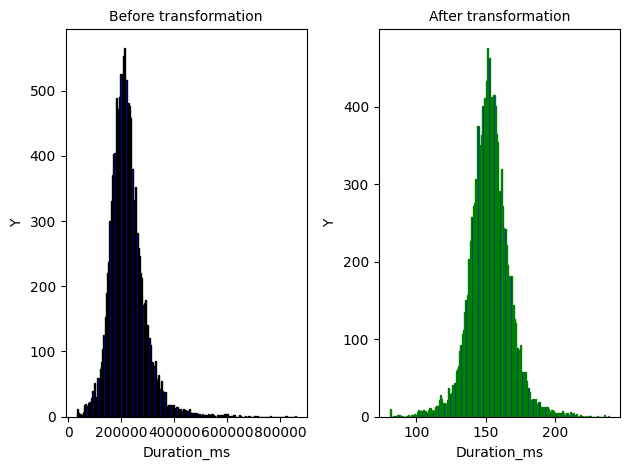

Lambda value used for Transformation: 0.31773056685911044


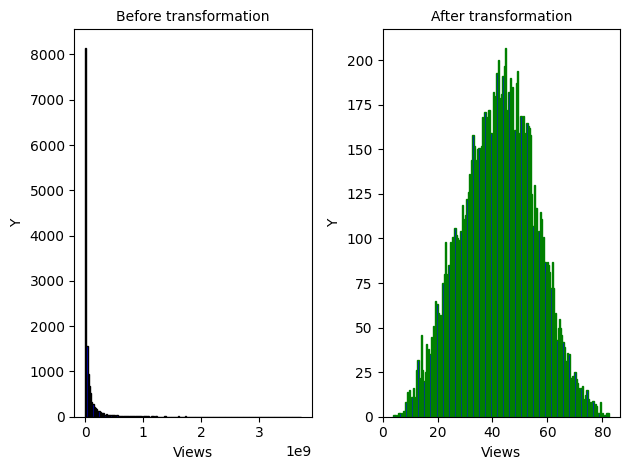

Lambda value used for Transformation: 0.10156044067199684


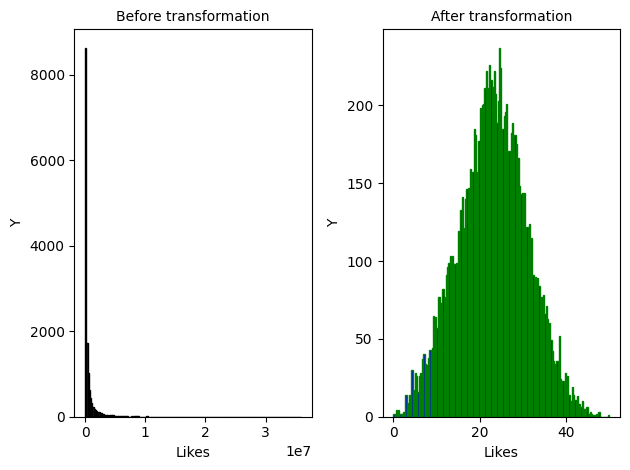

Lambda value used for Transformation: 0.10579676188111083


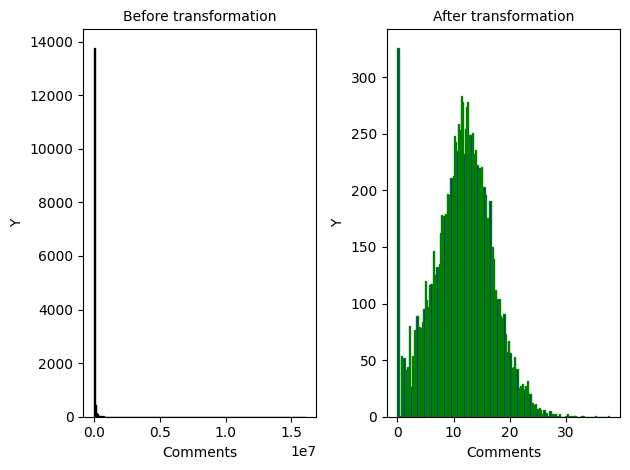

Lambda value used for Transformation: 0.08847159794297911


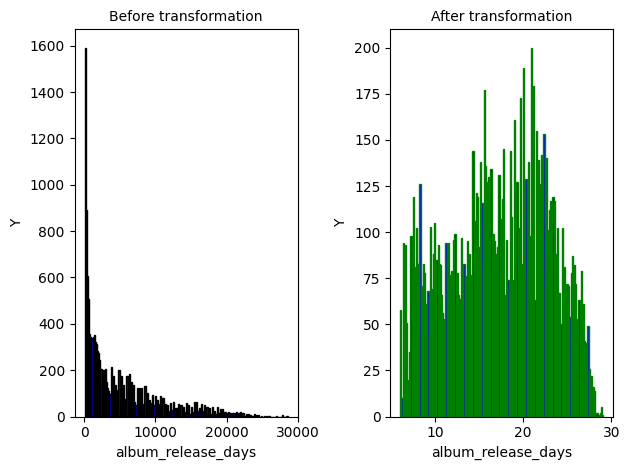

Lambda value used for Transformation: 0.17700912618853393


In [10]:
columns_box=['Duration_ms','Views','Likes','Comments','album_release_days']
transformed_columns=[]
for col in columns_box:
    fitted_data, fitted_lambda=boxcoxTransformation(X[col]+1,col)
    X[col]=fitted_data

In [11]:
X.loc[:,columns_box]

,Duration_ms,Views,Likes,Comments,album_release_days
0,167.074632,46.675095,23.166520,12.372746,26.719155
1,166.757429,30.812364,13.170092,5.442314,24.041769
2,136.287747,12.579589,4.186447,1.474892,27.515096
3,146.324637,27.175089,17.494020,9.156299,6.178444
4,157.774519,32.836614,17.813941,9.696153,12.341834
...,...,...,...,...,...
14555,165.297617,57.055989,30.684279,15.928592,17.522379
14556,141.090102,36.041099,21.406648,10.967710,12.529669
14557,167.838159,38.862049,21.334460,11.140665,23.532893
14558,156.139783,55.820932,30.793589,15.647493,18.152346


### Transform target with Boxcox

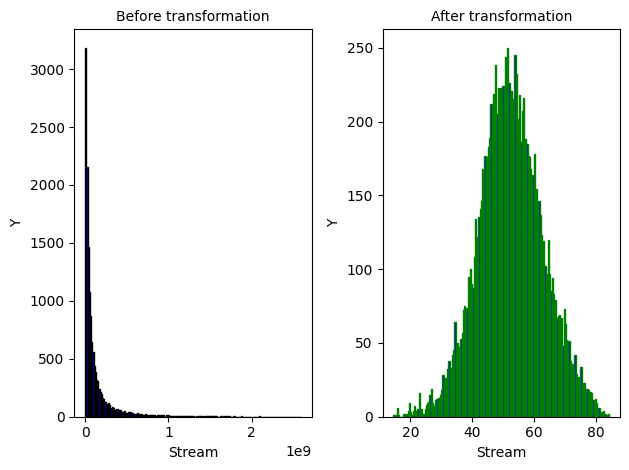

Lambda value used for Transformation: 0.10579596085309491


In [12]:
fitted_data, fitted_lambda=boxcoxTransformation(Y+1,'Stream')
Y=fitted_data

###  Auxiliar functions

In [13]:
def getBestFeatures(X_train,y_train,cv,scoring,clf):
    min_features_to_select = 5  # Minimum number of features to consider
#     clf =  DecisionTreeRegressor(random_state=0)
    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring=scoring,
        min_features_to_select=min_features_to_select,
        n_jobs=2,
    )
    rfecv.fit(X_train, y_train)
    mask = rfecv.get_support()
    return mask

In [14]:
from sklearn.metrics import accuracy_score
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print(predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
#     accuracy=accuracy_score(test_labels,predictions)
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

### Split the data into k-folds

In [15]:
k=10
# Create indices for k-fold cross-validation
indices = np.arange(len(X))
np.random.shuffle(indices)

# Split the data into k folds
folds = np.array_split(indices, k)

### Decision Tree

#### Decision Tree baseline model

In [17]:
maes = []
mses=[]
r2s=[]
rmses=[]

# Perform cross-validation
for i in range(k):
    # Split the data into train and test sets
    test_indices = folds[i]
    train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
    
    X_train, y_train = X.loc[train_indices], Y[train_indices]
    X_test, y_test = X.loc[test_indices], Y[test_indices]
    
    # Fit the model and make predictions
    model =  DecisionTreeRegressor(random_state=0)
    mask=getBestFeatures(X_train,y_train,3,'neg_mean_squared_error',model)
    
    X_train=X_train.iloc[:,mask]
    X_test=X_test.iloc[:,mask]
    
    
    model.fit(X_train, y_train)
    # Evaluate the model and store the score
    print("K=",i)
    base_accuracy = evaluate(model, X_test, y_test)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    mse=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    rmse = float(format(np.sqrt(sm.mean_squared_error(y_test, y_test_pred)), '.3f'))
    mae=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    r2=round(sm.r2_score(y_test, y_test_pred), 2)
    mses.append(mse)
    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)

K= 0
Average Error: 7.5131 degrees.
Accuracy = 85.10%.
K= 1
Average Error: 7.2891 degrees.
Accuracy = 85.36%.
K= 2
Average Error: 7.1679 degrees.
Accuracy = 85.68%.
K= 3
Average Error: 7.3174 degrees.
Accuracy = 85.53%.
K= 4
Average Error: 6.9906 degrees.
Accuracy = 86.15%.
K= 5
Average Error: 7.3226 degrees.
Accuracy = 85.12%.
K= 6
Average Error: 6.8007 degrees.
Accuracy = 86.50%.
K= 7
Average Error: 7.2722 degrees.
Accuracy = 85.27%.
K= 8
Average Error: 7.5152 degrees.
Accuracy = 85.22%.
K= 9
Average Error: 6.9248 degrees.
Accuracy = 86.32%.


In [19]:
maes = []
mses=[]
r2s=[]
rmses=[]

# Perform cross-validation
for i in range(k):
    # Split the data into train and test sets
    test_indices = folds[i]
    train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
    
    X_train, y_train = X.loc[train_indices], Y[train_indices]
    X_test, y_test = X.loc[test_indices], Y[test_indices]
    
    # Fit the model and make predictions
    model =  DecisionTreeRegressor(random_state=0)
    mask=getBestFeatures(X_train,y_train,3,'neg_mean_squared_error',model)
    
    X_train=X_train.iloc[:,mask]
    X_test=X_test.iloc[:,mask]
    
    
    model.fit(X_train, y_train)
    # Evaluate the model and store the score
    print("K=",i)
    base_accuracy = evaluate(model, X_test, y_test)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    mse=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    rmse = float(format(np.sqrt(sm.mean_squared_error(y_test, y_test_pred)), '.3f'))
    mae=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    r2=round(sm.r2_score(y_test, y_test_pred), 2)
    mses.append(mse)
    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)

    y_train_pred = model.predict(X_train)
    print("mse training",round(sm.mean_absolute_error(y_train, y_train_pred), 2))
    print("r2 training",round(sm.r2_score(y_train, y_train_pred), 2))
    break

K= 0
[52.62075502 65.50880793 38.25547584 ... 38.98161909 34.3593823
 47.93517561]
Average Error: 7.1334 degrees.
Accuracy = 85.62%.
mse training 0.0
r2 training 1.0


Average values of the metrics

In [ ]:
print("MSE: "+str(mses)+" "+ "Mean:"+str(np.mean(mses)))
print("RMSE: "+str(rmses)+" "+ "Mean:"+str(np.mean(rmses)))
print("MAE: "+str(maes)+" "+ "Mean:"+str(np.mean(maes)))
print("R2: "+str(r2s)+" "+ "Mean:"+str(np.mean(r2s)))

MSE: [7.51, 7.29, 7.17, 7.32, 6.99, 7.32, 6.8, 7.27, 7.52, 6.92] Mean:7.211
RMSE: [9.658, 9.601, 9.573, 9.532, 9.238, 9.581, 9.077, 9.596, 9.919, 9.254] Mean:9.5029
MAE: [7.51, 7.29, 7.17, 7.32, 6.99, 7.32, 6.8, 7.27, 7.52, 6.92] Mean:7.211
R2: [0.15, 0.17, 0.18, 0.12, 0.27, 0.22, 0.24, 0.14, 0.14, 0.2] Mean:0.183


### Hyperparameters tuning

In [ ]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)

In [ ]:
# Hyper parameters range intialization for tuning 
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [ ]:
# calculating different regression metrics
from sklearn.model_selection import GridSearchCV
model =  DecisionTreeRegressor(random_state=0)
tuning_model=GridSearchCV(model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [ ]:
from datetime import datetime
#code commented to avoid running the hyperparameters tuning process
# start_time=timer(None)

# tuning_model.fit(X,Y)

# timer(start_time)

In [ ]:
tuning_model.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

#### Best parameters

In [ ]:
# {'max_depth': 5,
#  'max_features': 'auto',
#  'max_leaf_nodes': 10,
#  'min_samples_leaf': 1,
#  'min_weight_fraction_leaf': 0.1,
#  'splitter': 'best'}

### Training Decision Tree With Best Hyperparameters

In [24]:
maes = []
mses=[]
r2s=[]
rmses=[]

# Perform cross-validation
for i in range(k):
    # Split the data into train and test sets
    test_indices = folds[i]
    train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
    
    X_train, y_train = X.loc[train_indices], Y[train_indices]
    X_test, y_test = X.loc[test_indices], Y[test_indices]
    
    
    # Fit the model and make predictions
    model =  DecisionTreeRegressor(max_depth= 5,max_features=1.0,
                                   max_leaf_nodes= 10,min_samples_leaf= 1,min_weight_fraction_leaf=0.1,splitter='best')
    
    mask=getBestFeatures(X_train,y_train,3,'neg_mean_squared_error',model)
    
    X_train=X_train.iloc[:,mask]
    X_test=X_test.iloc[:,mask]
    

    model.fit(X_train, y_train)
    # Evaluate the model and store the score
    print("K=",i)
    base_accuracy = evaluate(model, X_test, y_test)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    mse=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    rmse = float(format(np.sqrt(sm.mean_squared_error(y_test, y_test_pred)), '.3f'))
    mae=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    r2=round(sm.r2_score(y_test, y_test_pred), 2)
    mses.append(mse)
    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)
    

K= 0
Average Error: 6.2495 degrees.
Accuracy = 87.32%.
K= 1
Average Error: 6.1472 degrees.
Accuracy = 87.37%.
K= 2
Average Error: 6.0898 degrees.
Accuracy = 87.45%.
K= 3
Average Error: 5.9013 degrees.
Accuracy = 87.97%.
K= 4
Average Error: 6.0819 degrees.
Accuracy = 87.62%.
K= 5
Average Error: 6.0128 degrees.
Accuracy = 87.16%.
K= 6
Average Error: 6.0535 degrees.
Accuracy = 87.65%.
K= 7
Average Error: 6.1844 degrees.
Accuracy = 87.16%.
K= 8
Average Error: 6.0826 degrees.
Accuracy = 87.37%.
K= 9
Average Error: 5.8330 degrees.
Accuracy = 88.04%.


In [21]:
maes = []
mses=[]
r2s=[]
rmses=[]

# Perform cross-validation
for i in range(k):
    # Split the data into train and test sets
    test_indices = folds[i]
    train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
    
    X_train, y_train = X.loc[train_indices], Y[train_indices]
    X_test, y_test = X.loc[test_indices], Y[test_indices]
    
    
    # Fit the model and make predictions
    model =  DecisionTreeRegressor(max_depth= 5,max_features=1.0,
                                   max_leaf_nodes= 10,min_samples_leaf= 1,min_weight_fraction_leaf=0.1,splitter='best')
    
    mask=getBestFeatures(X_train,y_train,3,'neg_mean_squared_error',model)
    
    X_train=X_train.iloc[:,mask]
    X_test=X_test.iloc[:,mask]
    

    model.fit(X_train, y_train)
    # Evaluate the model and store the score
    print("K=",i)
    base_accuracy = evaluate(model, X_test, y_test)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    mse=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    rmse = float(format(np.sqrt(sm.mean_squared_error(y_test, y_test_pred)), '.3f'))
    mae=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    r2=round(sm.r2_score(y_test, y_test_pred), 2)
    mses.append(mse)
    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)
    
    y_train_pred = model.predict(X_train)
    print("mse training",round(sm.mean_absolute_error(y_train, y_train_pred), 2))
    print("r2 training",round(sm.r2_score(y_train, y_train_pred), 2))
    break

K= 0
[51.03125431 58.15907842 49.46578133 ... 49.46578133 40.03932397
 51.03125431]
Average Error: 6.1193 degrees.
Accuracy = 87.06%.
mse training 5.96
r2 training 0.45


We can see that the results improved significantly after hyperparameters tuning

In [ ]:
print("MSE: "+str(mses)+" "+ "Mean:"+str(np.mean(mses)))
print("RMSE: "+str(rmses)+" "+ "Mean:"+str(np.mean(rmses)))
print("MAE: "+str(maes)+" "+ "Mean:"+str(np.mean(maes)))
print("R2: "+str(r2s)+" "+ "Mean:"+str(np.mean(r2s)))


MSE: [6.25, 6.15, 6.09, 5.9, 6.08, 6.01, 6.05, 6.18, 6.08, 5.83] Mean:6.061999999999999
RMSE: [8.069, 7.894, 7.927, 7.586, 7.752, 7.808, 7.769, 7.964, 7.808, 7.557] Mean:7.8134
MAE: [6.25, 6.15, 6.09, 5.9, 6.08, 6.01, 6.05, 6.18, 6.08, 5.83] Mean:6.061999999999999
R2: [0.41, 0.44, 0.44, 0.44, 0.48, 0.48, 0.44, 0.41, 0.47, 0.47] Mean:0.44799999999999995


### Random Forest

#### Random Forest baseline model

In [22]:
k=10
maes = []
mses=[]
r2s=[]
rmses=[]

# Perform cross-validation
for i in range(k):
    # Split the data into train and test sets
    test_indices = folds[i]
    train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
    
    X_train, y_train = X.loc[train_indices], Y[train_indices]
    X_test, y_test = X.loc[test_indices], Y[test_indices]
    
    # Fit the model and make predictions
    model = RandomForestRegressor(n_estimators = 10, random_state = 42)
    mask=getBestFeatures(X_train,y_train,3,'neg_mean_squared_error',model)
    
    X_train=X_train.iloc[:,mask]
    X_test=X_test.iloc[:,mask]
    
    
    model.fit(X_train, y_train)
    # Evaluate the model and store the score
    print("K=",i)
    base_accuracy = evaluate(model, X_test, y_test)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    mse=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    rmse = float(format(np.sqrt(sm.mean_squared_error(y_test, y_test_pred)), '.3f'))
    mae=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    r2=round(sm.r2_score(y_test, y_test_pred), 2)
    mses.append(mse)
    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)


K= 0
[55.27357192 62.94653949 49.29640517 ... 49.5183737  42.97000282
 54.20432983]
Average Error: 5.3385 degrees.
Accuracy = 88.98%.
K= 1
[60.16781276 49.9555506  55.33166351 ... 67.36646784 62.60517487
 46.69881565]
Average Error: 5.0513 degrees.
Accuracy = 89.88%.
K= 2
[48.73918452 53.43725308 63.07309037 ... 54.44803354 50.81456838
 52.97989963]
Average Error: 5.3934 degrees.
Accuracy = 88.93%.
K= 3
[59.1517714  55.7146904  59.3194103  ... 58.6803438  48.21988444
 59.10297424]
Average Error: 5.1975 degrees.
Accuracy = 89.46%.
K= 4
[53.23501531 57.97256003 51.55077818 ... 55.16347975 30.43772377
 58.90676365]
Average Error: 5.1858 degrees.
Accuracy = 89.58%.
K= 5
[49.38443999 39.88542333 47.13171068 ... 64.5700826  58.27733293
 48.09843726]
Average Error: 5.3566 degrees.
Accuracy = 89.05%.
K= 6
[59.34714786 59.25453043 46.60066335 ... 56.74982673 50.51430976
 42.83697469]
Average Error: 5.0270 degrees.
Accuracy = 89.84%.
K= 7
[62.53478245 53.65368421 62.41568887 ... 51.13353249 47.5

With respect to the decision tree, the results are better

In [24]:
print("MSE: "+str(mses)+" "+ "Mean:"+str(np.mean(mses)))
print("RMSE: "+str(rmses)+" "+ "Mean:"+str(np.mean(rmses)))
print("MAE: "+str(maes)+" "+ "Mean:"+str(np.mean(maes)))
print("R2: "+str(r2s)+" "+ "Mean:"+str(np.mean(r2s)))

MSE: [5.34, 5.05, 5.39, 5.2, 5.19, 5.36, 5.03, 5.26, 5.15, 5.2] Mean:5.2170000000000005
RMSE: [7.001, 6.593, 7.248, 6.809, 6.705, 7.19, 6.588, 6.889, 6.691, 6.8] Mean:6.851400000000001
MAE: [5.34, 5.05, 5.39, 5.2, 5.19, 5.36, 5.03, 5.26, 5.15, 5.2] Mean:5.2170000000000005
R2: [0.58, 0.59, 0.48, 0.57, 0.57, 0.55, 0.58, 0.59, 0.58, 0.55] Mean:0.564


### Hyperparameters tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num = 8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.9s
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 2.1min
/shared-libs/python3.9/py/lib/py

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

#### Best hyperparameters

In [ ]:
# {'n_estimators': 600,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'max_depth': 80,
#  'bootstrap': False}

In [ ]:
best_random = rf_random.best_estimator_


### Train Random Forest with best parameters

In [ ]:
k=10
maes = []
mses=[]
r2s=[]
rmses=[]

# Perform cross-validation
for i in range(k):
    # Split the data into train and test sets
    test_indices = folds[i]
    train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
    
    X_train, y_train = X.loc[train_indices], Y[train_indices]
    X_test, y_test = X.loc[test_indices], Y[test_indices]
    
    mask=getBestFeatures(X_train,y_train,3,'neg_mean_squared_error',RandomForestRegressor(n_estimators = 10,random_state = 42))
    
    X_train=X_train.iloc[:,mask]
    X_test=X_test.iloc[:,mask]
    
    # Fit the model and make predictions
    model = RandomForestRegressor(n_estimators = 600,min_samples_split=2, min_samples_leaf=2,
    max_features='sqrt',max_depth=80,bootstrap=False)
    model.fit(X_train, y_train)
    
    # Evaluate the model and store the score
    print("K=",i)
    base_accuracy = evaluate(model, X_test, y_test)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    mse=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    rmse = float(format(np.sqrt(sm.mean_squared_error(y_test, y_test_pred)), '.3f'))
    mae=round(sm.mean_absolute_error(y_test, y_test_pred), 2)
    r2=round(sm.r2_score(y_test, y_test_pred), 2)
    mses.append(mse)
    r2s.append(r2)
    rmses.append(rmse)
    maes.append(mae)

K= 0
Average Error: 5.2246 degrees.
Accuracy = 89.54%.
K= 1
Average Error: 5.0603 degrees.
Accuracy = 89.79%.
K= 2
Average Error: 5.0366 degrees.
Accuracy = 89.74%.
K= 3
Average Error: 4.9020 degrees.
Accuracy = 90.11%.
K= 4
Average Error: 4.9869 degrees.
Accuracy = 89.93%.
K= 5
Average Error: 4.9741 degrees.
Accuracy = 89.68%.
K= 6
Average Error: 4.8960 degrees.
Accuracy = 90.25%.
K= 7
Average Error: 5.1269 degrees.
Accuracy = 89.48%.
K= 8
Average Error: 5.0796 degrees.
Accuracy = 89.79%.
K= 9
Average Error: 4.8260 degrees.
Accuracy = 90.19%.


We can see that the performance improved a bit

In [ ]:
print("MSE: "+str(mses)+" "+ "Mean:"+str(np.mean(mses)))
print("RMSE: "+str(rmses)+" "+ "Mean:"+str(np.mean(rmses)))
print("MAE: "+str(maes)+" "+ "Mean:"+str(np.mean(maes)))
print("R2: "+str(r2s)+" "+ "Mean:"+str(np.mean(r2s)))

MSE: [5.22, 5.06, 5.04, 4.9, 4.99, 4.97, 4.9, 5.13, 5.08, 4.83] Mean:5.012
RMSE: [6.866, 6.683, 6.662, 6.491, 6.537, 6.516, 6.374, 6.695, 6.625, 6.36] Mean:6.5809
MAE: [5.22, 5.06, 5.04, 4.9, 4.99, 4.97, 4.9, 5.13, 5.08, 4.83] Mean:5.012
R2: [0.57, 0.6, 0.6, 0.59, 0.63, 0.64, 0.62, 0.58, 0.62, 0.62] Mean:0.607


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c6bca811-fc7a-456b-b8f3-4c66c733d95a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>